# Initial Setup

In [50]:
%load_ext autoreload
%autoreload 2

from random import random
import pandas as pd
import matplotlib
import numpy as np
from sklearn import metrics
import csv
import time
import datetime
import itertools
from dateutil.relativedelta import relativedelta

import yfinance as yf
from alpha_vantage.timeseries import TimeSeries
import pandas_market_calendars as mcal

import pmdarima as pm
import prophet
from statsmodels.tsa.stattools import adfuller, pacf, acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# from pathlib import Path
# import os
# current_path = os.getcwd()
# # top = Path(__file__ + '..').resolve()
import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()
sys.path
# sys.path.insert(0, top/ 'code')
# sys.path.insert(0, top/ 'auth')
# sys.path.insert(0, '../code')
# sys.path.insert(0, '../auth')
# sys.path.insert(0, '../')

# arrow = top / 'assets/arrow.png'
# print('source image:', arrow)

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from functions import *

# only display whole years in figures
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

from keys import client_id, secret_key, av_key, consumer_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Get NYSE calendar

In [3]:
NYSE = mcal.get_calendar('NYSE')
early = NYSE.schedule(start_date='2012-07-01', end_date='2012-07-10')
early;

## Set up Frequency Variables

### Custom Business Hour

In [4]:
cbh = pd.offsets.CustomBusinessHour(calendar=NYSE, start='05:00', end='21:00')
cbh

<CustomBusinessHour: CBH=05:00-21:00>

### Custom Business Day

In [5]:
cbd = pd.offsets.CustomBusinessDay(calendar=NYSE)
cbd

<CustomBusinessDay>

# Alpha Vantage

## Setup

### Initialize Alpha Vantage parameters

In [6]:
ts = TimeSeries(key=av_key, output_format='csv')
AV_COLUMNS = ['time', 'open', 'high', 'low', 'close', 'volume']

## Gather Data

### Last Two Years, 60min

In [7]:
# df_full = get_av_all_data_slices('SPY', ts, interval='60min', verbose=0)
# df_full.to_csv('../data/SPY_2019_2021.csv')

### Last Month, 60min

In [8]:
# df_last_month = get_av_all_data_slices('SPY', ts, y=1, m=1, interval='60min', verbose=0)
# df_last_month.index = pd.to_datetime(df_last_month.index)
# df_last_month.to_csv('../data/SPY_Last_Month_CBH.csv')

### Last 5 days, 1min

In [9]:
# df_last_month_1min = get_av_all_data_slices('SPY', ts, y=1, m=1, interval='1min', verbose=1)
# df_last_month_1min.index = pd.to_datetime(df_last_month_1min.index)
# df_last_month_1min.to_csv('../data/SPY_Last_Month_1min.csv')

In [10]:
# df_last_5d_1min = df_last_month_1min[df_last_month_1min.index.date > (df_last_month_1min[:1].index.date - 5*cbd)]
# df_last_5d_1min.to_csv('../data/SPY_Last_5d_1min.csv')

In [11]:
# df_last_1min[:1].index.date - 5*cbd

In [12]:
# (pd.date_range(df_last_month_1min[:1].index[0], periods = 5, freq=-cbd)).date

In [13]:
# ticker = 'SPY'
# date= 'year1month10'
# apiKey = av_key

# df_new = pd.read_csv('https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY_EXTENDED&symbol='+ticker+'&interval=60min&slice='+date+'&apikey='+apiKey+'&datatype=csv&outputsize=full') 

## Load Data from File

In [14]:
# df_full = pd.read_csv('../data/SPY_2019_2021_CBH.csv', index_col='time')
df_full = pd.read_csv('../data/SPY_2019_2021_CBD.csv', index_col='time')
df_full.index = pd.to_datetime(df_full.index)

In [15]:
df_last_month = pd.read_csv('../data/SPY_Last_Month_CBH.csv', index_col='time')
df_last_month.index = pd.to_datetime(df_last_month.index)

In [16]:
df_last_5d_1min = pd.read_csv('../data/SPY_Last_5d_1min.csv', index_col='time')
df_last_5d_1min.index = pd.to_datetime(df_last_5d_1min.index)

## Append Latest Data

## Data Preparation

### Set Frequencies

In [17]:
df_full = df_full.sort_index()
df_full = df_full.asfreq(cbd)

In [18]:
df_last_month = df_last_month.sort_index()
df_last_month = df_last_month.asfreq(cbh)

In [19]:
df_last_5d_1min = df_last_5d_1min.sort_index()
df_last_5d_1min = df_last_5d_1min.asfreq('T')

In [20]:
df_last_5d_1min

,open,high,low,close,volume
time,,,,,
2021-04-22 04:01:00,415.61,415.61,415.52,415.60,9244.0
2021-04-22 04:02:00,415.63,415.63,415.60,415.61,2860.0
2021-04-22 04:03:00,415.60,415.64,415.60,415.61,2990.0
2021-04-22 04:04:00,415.63,415.63,415.63,415.63,510.0
2021-04-22 04:05:00,415.63,415.66,415.61,415.65,1011.0
...,...,...,...,...,...
2021-04-28 19:56:00,418.40,418.44,418.40,418.44,6269.0
2021-04-28 19:57:00,418.44,418.48,418.44,418.48,1574.0
2021-04-28 19:58:00,418.46,418.50,418.46,418.50,2127.0


### EDA

In [21]:
df_full.isna().sum(), df_last_month.isna().sum(), df_last_5d_1min.isna().sum()

(open      18
 high      18
 low       18
 close     18
 volume    18
 dtype: int64,
 open      16
 high      16
 low       16
 close     16
 volume    16
 dtype: int64,
 open      5673
 high      5673
 low       5673
 close     5673
 volume    5673
 dtype: int64)

In [22]:
pd.DataFrame(df_full.index.date).value_counts(), pd.DataFrame(df_last_month.index.date).value_counts(), pd.DataFrame(df_last_5d_1min.index.date).value_counts()

(2019-05-07    1
 2020-10-27    1
 2020-09-09    1
 2020-09-08    1
 2020-09-07    1
              ..
 2019-12-25    1
 2019-12-24    1
 2019-12-23    1
 2019-12-20    1
 2021-04-23    1
 Length: 514, dtype: int64,
 2021-03-30    16
 2021-03-31    16
 2021-04-27    16
 2021-04-26    16
 2021-04-23    16
 2021-04-22    16
 2021-04-21    16
 2021-04-20    16
 2021-04-19    16
 2021-04-16    16
 2021-04-15    16
 2021-04-14    16
 2021-04-13    16
 2021-04-12    16
 2021-04-09    16
 2021-04-08    16
 2021-04-07    16
 2021-04-06    16
 2021-04-05    16
 2021-04-02    16
 2021-04-01    16
 2021-04-28    16
 dtype: int64,
 2021-04-23    1440
 2021-04-24    1440
 2021-04-25    1440
 2021-04-26    1440
 2021-04-27    1440
 2021-04-28    1201
 2021-04-22    1199
 dtype: int64)

In [23]:
# try:
#     assert(type(df_new)=='pandas.core.frame.DataFrame')
# except AssertionError:
#     print('Nothing to append.')
# else:
#     df_full = df_full.append(df_new)
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
# finally:
#     df_full = df_full.sort_index()
#     df_full = df_full.asfreq(cbh)
#     df_full.to_csv('../data/SPY_2019_2021.csv')
#     df_full

### Create Time Series for `Close`, `Volume`

In [25]:
df_full_close = df_full.close
df_last_month_close = df_last_month.close
df_last_5d_1min_close = df_last_5d_1min.close
print(df_last_month_close[-16:])
print()
print(df_last_5d_1min_close[-60:])

time
2021-04-28 05:00:00    417.8700
2021-04-28 06:00:00    417.7900
2021-04-28 07:00:00    417.9000
2021-04-28 08:00:00    417.4600
2021-04-28 09:00:00    417.6800
2021-04-28 10:00:00    418.3800
2021-04-28 11:00:00    418.0319
2021-04-28 12:00:00    417.2919
2021-04-28 13:00:00    417.8090
2021-04-28 14:00:00    417.3100
2021-04-28 15:00:00    418.3300
2021-04-28 16:00:00    417.3500
2021-04-28 17:00:00    418.0800
2021-04-28 18:00:00    418.0000
2021-04-28 19:00:00    418.2200
2021-04-28 20:00:00    418.4700
Freq: CBH, Name: close, dtype: float64

time
2021-04-28 19:01:00    418.30
2021-04-28 19:02:00    418.27
2021-04-28 19:03:00    418.29
2021-04-28 19:04:00    418.30
2021-04-28 19:05:00       NaN
                        ...  
2021-04-28 19:56:00    418.44
2021-04-28 19:57:00    418.48
2021-04-28 19:58:00    418.50
2021-04-28 19:59:00    418.49
2021-04-28 20:00:00    418.47
Freq: T, Name: close, Length: 60, dtype: float64


In [26]:
vol_full = df_full.volume
vol_last_month = df_last_month.volume
vol_last_5d_1min = df_last_5d_1min.volume
print(vol_last_month[-16:])
print()
print(vol_last_5d_1min[-60:])

time
2021-04-28 05:00:00       19891.0
2021-04-28 06:00:00        9111.0
2021-04-28 07:00:00       27097.0
2021-04-28 08:00:00      156203.0
2021-04-28 09:00:00       80054.0
2021-04-28 10:00:00     5654960.0
2021-04-28 11:00:00     4954183.0
2021-04-28 12:00:00     4875257.0
2021-04-28 13:00:00     2933922.0
2021-04-28 14:00:00     2843849.0
2021-04-28 15:00:00     9781781.0
2021-04-28 16:00:00    15078124.0
2021-04-28 17:00:00     3608693.0
2021-04-28 18:00:00      186049.0
2021-04-28 19:00:00      128157.0
2021-04-28 20:00:00       42013.0
Freq: CBH, Name: volume, dtype: float64

time
2021-04-28 19:01:00    6142.0
2021-04-28 19:02:00     605.0
2021-04-28 19:03:00     605.0
2021-04-28 19:04:00     100.0
2021-04-28 19:05:00       NaN
                        ...  
2021-04-28 19:56:00    6269.0
2021-04-28 19:57:00    1574.0
2021-04-28 19:58:00    2127.0
2021-04-28 19:59:00    4522.0
2021-04-28 20:00:00    2319.0
Freq: T, Name: volume, Length: 60, dtype: float64


In [27]:
df_full.index, df_last_month.index, df_last_5d_1min.index

(DatetimeIndex(['2019-05-07 05:00:00', '2019-05-08 05:00:00',
                '2019-05-09 05:00:00', '2019-05-10 05:00:00',
                '2019-05-13 05:00:00', '2019-05-14 05:00:00',
                '2019-05-15 05:00:00', '2019-05-16 05:00:00',
                '2019-05-17 05:00:00', '2019-05-20 05:00:00',
                ...
                '2021-04-12 05:00:00', '2021-04-13 05:00:00',
                '2021-04-14 05:00:00', '2021-04-15 05:00:00',
                '2021-04-16 05:00:00', '2021-04-19 05:00:00',
                '2021-04-20 05:00:00', '2021-04-21 05:00:00',
                '2021-04-22 05:00:00', '2021-04-23 05:00:00'],
               dtype='datetime64[ns]', name='time', length=514, freq='C'),
 DatetimeIndex(['2021-03-30 05:00:00', '2021-03-30 06:00:00',
                '2021-03-30 07:00:00', '2021-03-30 08:00:00',
                '2021-03-30 09:00:00', '2021-03-30 10:00:00',
                '2021-03-30 11:00:00', '2021-03-30 12:00:00',
                '2021-03-30 13:00:00

In [28]:
vol_full, vol_last_month, vol_last_5d_1min

(time
 2019-05-07 05:00:00    34989.0
 2019-05-08 05:00:00    23984.0
 2019-05-09 05:00:00    48671.0
 2019-05-10 05:00:00    30085.0
 2019-05-13 05:00:00    79225.0
                         ...   
 2021-04-19 05:00:00    25802.0
 2021-04-20 05:00:00    41214.0
 2021-04-21 05:00:00     7799.0
 2021-04-22 05:00:00    42369.0
 2021-04-23 05:00:00    18304.0
 Freq: C, Name: volume, Length: 514, dtype: float64,
 time
 2021-03-30 05:00:00       11096.0
 2021-03-30 06:00:00       18872.0
 2021-03-30 07:00:00      143570.0
 2021-03-30 08:00:00      213908.0
 2021-03-30 09:00:00      324577.0
                           ...    
 2021-04-28 16:00:00    15078124.0
 2021-04-28 17:00:00     3608693.0
 2021-04-28 18:00:00      186049.0
 2021-04-28 19:00:00      128157.0
 2021-04-28 20:00:00       42013.0
 Freq: CBH, Name: volume, Length: 352, dtype: float64,
 time
 2021-04-22 04:01:00    9244.0
 2021-04-22 04:02:00    2860.0
 2021-04-22 04:03:00    2990.0
 2021-04-22 04:04:00     510.0
 2021-04-22 0

## Plot PACF

In [24]:
plot_pacf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

NameError: name 'vol_last_5d_1min' is not defined

In [ ]:
plot_pacf_with_diff(df_last_5d_1min_close, 'SPY \'Close\'', '5 Days', '1 Min')

## Plot ACF

In [ ]:
plot_acf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

## Plot Seasonal Decomposition

### 2019-2021, Freq = Custom Business Day, Quarterly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_close.dropna(), 'SPY', round(365/4), 'days')

### Last Month, Freq = Custom Business Hour, 5 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_month_close.dropna(), 'SPY', 16*5, 'hours')

### Last 5 Days, Freq = Minute, 1 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_5d_1min_close.dropna(), 'SPY', int(24*60), 'minutes')

### Test out read and write CSV at same time

In [ ]:
# with open('../data/GME_intra_Mar_29_Apr_12.csv', newline='') as csvfile:
# #     fieldnames = ['first_name', 'last_name']
#     reader = csv.reader(csvfile)
#     fieldnames = next(reader)
#     print(fieldnames)
    
#     with open('../data/output.csv', mode='w', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow(fieldnames)
#         for row in reader:
#             writer.writerow(row)
            

### Scratch

In [ ]:
# df_full[df_full.index>'2020-07-03']

In [ ]:
# df_full[(df_full.index>'2020-07-03') & (df_full.index<'2020-07-04')]

In [ ]:
# start = pd.to_datetime('2019-06-07')

In [ ]:
# cbh.next_bday(pd.to_datetime(start))

In [ ]:
# start + pd.DateOffset(days = 2)

In [ ]:
# start + pd.offsets.BDay()

In [ ]:
# df_copy = df_full.copy()
# df_copy.index = df_copy.index.date
# df_copy.index.value_counts()

In [ ]:
# df_copy_2 = df_full2.copy()
# df_copy_2.index = df_copy_2.index.date
# df_copy_2.index.value_counts()

In [ ]:
# df_full2[df_full2.index.date == pd.to_datetime('2020-07-06')]

In [ ]:
# df_full[df_full.index.date == pd.to_datetime('2021-03-01')]

In [ ]:
# null_data = df_full[df_full.isnull().any(axis=1)]
# null_data

In [ ]:
# null_data2 = df_full2[df_full2.isnull().any(axis=1)]
# null_data2

In [ ]:
# y=1
# m=11
# data_slice = f'year{y+1}month{m+1}'
# print(data_slice)
# total_data_reader, total_meta_data = ts.get_intraday_extended(symbol='SPY', interval='60min', slice=data_slice)
# fieldnames = next(total_data_reader)
# print(fieldnames)
# df_test = pd.DataFrame(total_data_reader, columns=fieldnames)
# df_test.set_index('time', inplace=True)
# df_test

In [ ]:
# with open('../data/output.csv', mode='w', newline='') as csvfile:
# #     writer = csv.DictWriter(csvfile, fieldnames=df_test_dict.keys())
# #     writer = csv.DictWriter(sys.stderr, fieldnames=df_test_dict.keys())
# #     writer = csv.writer(sys.stderr)
#     writer = csv.writer(csvfile)
#     writer.writerow(df_test.reset_index().columns)
# #     writer.writeheader()
#     writer.writerows(df_test.reset_index().values)

In [ ]:
# df_test_close = df_test.close

## Check Stationarity

In [ ]:
test_stationarity(df_full_close.dropna())
print()
test_stationarity(df_last_month_close.dropna())
print()
test_stationarity(df_last_5d_1min_close.dropna())

In [ ]:
test_stationarity(df_full_close.dropna(), 1)
print()
test_stationarity(df_last_month_close.dropna(), 1)
print()
test_stationarity(df_last_5d_1min_close.dropna(), 1)

## Plot PACF

In [ ]:
plot_pacf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

In [ ]:
plot_pacf_with_diff(df_last_5d_1min_close, 'SPY \'Close\'', '5 Days', '1 Min')

## Plot ACF

In [ ]:
plot_acf_with_diff(vol_last_5d_1min, 'SPY \'Volume\'', '5 Days', '1 Min')

## Plot Seasonal Decomposition

### 2019-2021, Freq = Custom Business Day, Quarterly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_close.dropna(), 'SPY', round(365/4), 'days')

### Last Month, Freq = Custom Business Hour, 5 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_month_close.dropna(), 'SPY', 16*5, 'hours')

### Last 5 Days, Freq = Minute, 1 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_5d_1min_close.dropna(), 'SPY', int(24*60), 'minutes')

In [ ]:
decomp = seasonal_decompose(df_last_5d_1min_close.dropna(), period=int(6.5*60))
dc_obs = decomp.observed
dc_trend = decomp.trend
dc_seas = decomp.seasonal
dc_resid = decomp.resid
dc_df = pd.DataFrame({"observed": dc_obs, "trend": dc_trend,
                            "seasonal": dc_seas, "residual": dc_resid})

In [ ]:
dc_df.iloc[:,0].index[0]

In [ ]:
dc_df.iloc[:,0].dropna()

In [ ]:
pd.date_range(dc_df.iloc[:,0][.size)

In [ ]:
range(dc_df.iloc[:,0].size)

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(dc_df.iloc[:,0].dropna().size), dc_df.iloc[:,0].dropna())
# ax.set_xticklabels(dc_df.dropna().index.date.tolist());
ax.set_xticklabels(dc_df.iloc[:,0].dropna().index.date.tolist());
fig.autofmt_xdate()

In [ ]:
fig, ax = plt.subplots()
ax.plot(dc_df.iloc[:,0].dropna().index, dc_df.iloc[:,0].dropna())
# ax.set_xticklabels(dc_df.dropna().index.date.tolist());
# fig.autofmt_xdate()

In [ ]:
dc_df.dropna().index.date.tolist()

In [ ]:
dc_df.iloc[:,0].dropna().index.date.tolist()

In [ ]:
delta={}
delta['minutes'] = 15

In [ ]:
end = dc_df.iloc[:, 0].index[-1] + relativedelta(**delta)
end

In [ ]:
new = dc_df.iloc[:,0].resample('T').mean()

In [ ]:
new.dropna().plot()

# YFinance

## Setup / Gather Data

In [85]:
ticker = 'SPY'

In [92]:
spy_df = yf.download(ticker, start='2018-05-01', end='2021-05-01', progress=False)
spy_df.index = spy_df.index.rename('date')
spy_df.columns = ['open', 'high', 'low', 'close', 'adj_close', 'volume']
spy_df.to_csv('../data/SPY_3Y_CBD.csv')

## Load Data from File

In [100]:
spy_df = pd.read_csv('../data/SPY_3Y_CBD.csv', index_col='date')
spy_df.index = pd.to_datetime(spy_df.index)

## Data Preparation

### EDA

In [101]:
spy_df

,open,high,low,close,adj_close,volume
date,,,,,,
2018-05-01,263.869995,265.100006,262.109985,264.980011,250.711670,74203400
2018-05-02,264.760010,265.679993,262.760010,263.200012,249.027512,86368900
2018-05-03,262.260010,263.359985,259.049988,262.619995,248.478745,136311500
2018-05-04,261.519989,266.790009,261.149994,266.019989,251.695648,91222100
2018-05-07,266.890015,268.019989,266.109985,266.920013,252.547226,55304900
...,...,...,...,...,...,...
2021-04-26,417.440002,418.220001,416.809998,417.609985,417.609985,52182400
2021-04-27,417.929993,418.140015,416.299988,417.519989,417.519989,51303100
2021-04-28,417.809998,419.010010,416.899994,417.399994,417.399994,51238900


In [32]:
spy_df.isna().sum()

open         0
high         0
low          0
close        0
adj_close    0
volume       0
dtype: int64

### Set up Frequency

In [33]:
spy_df = spy_df.asfreq(cbd)

In [34]:
spy_df.isna().sum()

open         28
high         28
low          28
close        28
adj_close    28
volume       28
dtype: int64

### Create Time Series for `Close`, `Volume`

In [102]:
df_full_close = spy_df.close
df_full_vol = spy_df.volume

In [36]:
df_full_close

Date
2018-05-01    264.980011
2018-05-02    263.200012
2018-05-03    262.619995
2018-05-04    266.019989
2018-05-07    266.920013
                 ...    
2021-04-26    417.609985
2021-04-27    417.519989
2021-04-28    417.399994
2021-04-29    420.059998
2021-04-30    417.500000
Freq: C, Name: close, Length: 784, dtype: float64

## Plot PACF

In [ ]:
plot_pacf_with_diff(df_full_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

In [ ]:
plot_pacf_with_diff(df_full_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot ACF

In [ ]:
plot_acf_with_diff(df_full_vol, 'SPY \'Volume\'', 3, 'years', '1 Day', lags=60)

In [ ]:
plot_acf_with_diff(df_full_close, 'SPY \'Close\'', 3, 'years', '1 Day', lags=60)

## Plot Seasonal Decomposition

In [ ]:
start = pd.to_datetime('2020-07-01')

In [ ]:
freq =  '1 Day'
freq.split()[1].lower() + 's'

### 2018-2021, Freq = Custom Business Day, Quarterly Seasonality

In [ ]:
plot_seasonal_decomposition(df_full_close.dropna(), 'SPY \'Volume\'', 3, 'years', '1 Day', 365)

### 5 Years, Freq = Custom Business Hour, 1 Year Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_month_close.dropna(), 'SPY \'Volume\'', 5, 'years', '1 Day', 365)

### Last 5 Days, Freq = Minute, 1 Day Seasonality

In [ ]:
plot_seasonal_decomposition(df_last_5d_1min_close.dropna(), 'SPY', int(24*60), 'minutes')

# Quandl

# Modeling

## Last 3 Years, 1 Day

In [103]:
df_train, df_test, vol_train, vol_test = run_full_pdarima(df_full_close, df_full_vol, 80, 1)

##### Train-Test Split #####
Using a 80/20 train-test split...
##### Train-Test Split #####
Using a 80/20 train-test split...


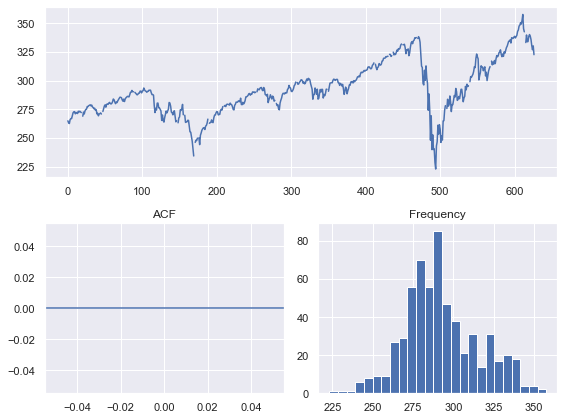

In [51]:
pm.tsdisplay(df_train, lag_max=10)

In [65]:
y, X = load_date_example()
y_train, y_test, X_train, X_test = \
    pm.model_selection.train_test_split(y, X, test_size=20)

In [104]:
pd.DataFrame(df_train.index)

,date
0,2018-05-01
1,2018-05-02
2,2018-05-03
3,2018-05-04
4,2018-05-07
...,...
600,2020-09-17
601,2020-09-18
602,2020-09-21
603,2020-09-22


In [105]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",  # the name of the date feature in the X matrix
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(df_train.values, pd.DataFrame(df_train.index))

In [106]:
X_train_feats

,DATE-WEEKDAY-0,DATE-WEEKDAY-1,DATE-WEEKDAY-2,DATE-WEEKDAY-3,DATE-WEEKDAY-4,DATE-WEEKDAY-5,DATE-WEEKDAY-6,DATE-DAY-OF-MONTH
0,0,1,0,0,0,0,0,1
1,0,0,1,0,0,0,0,2
2,0,0,0,1,0,0,0,3
3,0,0,0,0,1,0,0,4
4,1,0,0,0,0,0,0,7
...,...,...,...,...,...,...,...,...
600,0,0,0,1,0,0,0,17
601,0,0,0,0,1,0,0,18
602,1,0,0,0,0,0,0,21
603,0,1,0,0,0,0,0,22


## Last 5 Days, 1min

### Train-Test Split

In [ ]:
# round((80/100)*len(df))

In [41]:
# df_train, df_test = train_test_split_data(df, 80)
df_train_last_5d_1min, df_test_last_5d_1min = train_test_split_data(df_last_5d_1min_close, 80)
vol_train_last_5d_1min, vol_test_last_5d_1min = train_test_split_data(vol_last_5d_1min, 80)

#### No Seasonality

In [ ]:
# Train Set
pm.auto_arima(vol_train_last_5d_1min.dropna()).summary()

In [45]:
# Full Set
pm.auto_arima(vol_last_5d_1min.dropna()).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3927
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -52221.109
Date:                Thu, 29 Apr 2021   AIC                         104462.219
Time:                        17:04:07   BIC                         104524.972
Sample:                             0   HQIC                        104484.484
                               - 3927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3895      0.078     -5.005      0.000      -0.542      -0.237
ar.L2         -0.0796      0.041     -1.920      0.055      -0.161       0.002
ar.L3          0.4202      0.062      6.764      0.000       0.298       0.542
ar.L4          0.5403      0.063      8.637      0.000       0.418       0.663
ma.L1         -0.2453      0.077     -3.172      0.002      -0.397      -0.094
ma.L2         -0.2847      0.071     -4.009      0.000      -0.424      -0.146
ma.L3         -0.5526      0.067     -8.193      0.000      -0.685      -0.420
ma.L4         -0.3067      0.095     -3.213      0.001      -0.494      -0.120
ma.L5          0.4222      0.035     11.942      0.000       0.353       0.492
sigma2      2.146e+10   3.57e-11   6.01e+20      0.000    2.15e+10    2.15e+10
===================================================================================
Ljung-Box (Q):                       67.42   Jarque-Bera (JB):           3955420.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             8.61
Prob(H) (two-sided):                  0.00   Kurtosis:                       157.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.02e+35. Standard errors may be unstable.
"""

#### 1 Day Seasonality

##### Train Set

In [ ]:
# pm.auto_arima(vol_train_last_5d_1min.dropna(), seasonal=True, m=24*60).summary()

##### Full Set

In [ ]:
# pm.auto_arima(vol_last_5d_1min.dropna(), seasonal=True, m=24*60).summary()

In [ ]:
# param_list = []
# param_seasonal_list = []
# aic_list = []

In [ ]:
# param = (2,1,0)
# param_seasonal = (2,1,0,2190)

In [ ]:
# mod = SARIMAX(df_train,
#               order=param,
#               seasonal_order=param_seasonal,
#               enforce_stationarity=False,
#               enforce_invertibility=False,
#               verbose=True).fit()
# param_list.append(param)
# param_seasonal_list.append(param_seasonal)
# aic = mod.aic

In [ ]:
# param_list, param_seasonal_list, aic_list = gridsearch_SARIMAX(df_train)

## Auto ARIMA

In [ ]:
# pm.auto_arima(df.dropna(), seasonal=True, m=2190).summary()
# pm.auto_arima(df.dropna(), seasonal=True, m=round(365/4)).summary()

### Last 5 Days, 1min - `Close`

In [ ]:
# Train Set
# pm.auto_arima(df_train_last_5d_1min.dropna(), exog=vol_train_last_5d_1min).summary()

In [46]:
# Full Set
pm.auto_arima(df_last_5d_1min_close.dropna(), exog=vol_last_5d_1min).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3927
Model:               SARIMAX(1, 1, 3)   Log Likelihood                3921.866
Date:                Thu, 29 Apr 2021   AIC                          -7833.733
Time:                        17:05:14   BIC                          -7802.356
Sample:                             0   HQIC                         -7822.600
                               - 3927                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8036      0.061    -13.280      0.000      -0.922      -0.685
ma.L1          0.8304      0.062     13.422      0.000       0.709       0.952
ma.L2         -0.0064      0.010     -0.628      0.530      -0.026       0.014
ma.L3         -0.0552      0.008     -7.132      0.000      -0.070      -0.040
sigma2         0.0079   5.38e-05    147.619      0.000       0.008       0.008
===================================================================================
Ljung-Box (Q):                       72.61   Jarque-Bera (JB):             87775.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.43   Skew:                            -0.79
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### 1 Day Seasonality

##### Train Set

In [ ]:
# pm.auto_arima(df_train_last_5d_1min.dropna(), exog=vol_train_last_5d_1min, seasonal=True, m=24*60).summary()

##### Full Set

In [ ]:
# pm.auto_arima(df_last_5d_1min.dropna(), exog=vol_last_5d_1min, seasonal=True, m=24*60).summary()

In [ ]:
# pm.auto_arima(df_last_5d_1min_close.dropna(), exog=vol_last_5d_1min, exog=vol_train, seasonal=True, m=16*5).summary()

## SARIMAX Fitting

In [ ]:
df_test_last_5d_1min

In [ ]:
df_train_last_5d_1min.isna().index

In [ ]:
df_test_last_5d_1min

### Last 5 Days, Freq = Minute

#### No Seasonality

In [ ]:
# sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(4,1,5)).fit()
# sari_mod_volume.summary()
# failed to converge

In [40]:
sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(4,1,5)).fit()
sari_mod_volume.summary()

NameError: name 'vol_train_last_5d_1min' is not defined

In [ ]:
sari_mod_close = SARIMAX(df_train_last_5d_1min, order=(1,1,3), exog=vol_train_last_5d_1min.dropna()).fit()
sari_mod_close.summary()

#### 1 Day Seasonality

In [ ]:
# sari_mod_volume = SARIMAX(vol_train_last_5d_1min, order=(1,1,0),seasonal_order=(1,1,0,24*60)).fit()
# sari_mod_volume.summary()

In [ ]:
# sari_mod_close = SARIMAX(df_train_last_5d_1min, order=(1,1,0), exog=vol_train_last_5d_1min.dropna(), seasonal_order=(1,1,0,24*60)).fit()
# sari_mod_close.summary()

In [ ]:
df_test_last_5d_1min.index[0]

## Simple Test vs Predict

### Last 5 Days, 1min - `Volume`

#### No Seasonality

In [ ]:
v_hat_train_last_5d_1min = sari_mod_close.predict(typ='levels', dynamic=False)
v_hat_test_last_5d_1min = sari_mod_close.predict(start=vol_test_last_5d_1min.index[0], end=vol_test_last_5d_1min.index[-1], typ='levels')

### Last 5 Days, 1min - `Close`

In [ ]:
y_hat_train_last_5d_1min = sari_mod_close.predict(typ='levels', dynamic=False)
y_hat_test_last_5d_1min = sari_mod_close.predict(start=df_test_last_5d_1min.index[0], end=df_test_last_5d_1min.index[-1], typ='levels')

#### 1 Day Seasonality

### Visualization

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
ax.plot(df_train_last_5d_1min, label='Train')
ax.plot(df_test_last_5d_1min, label='Test')
ax.plot(y_hat_train_last_5d_1min, label='Train Predictions')
ax.plot(y_hat_test_last_5d_1min, label='Test Predictions')
ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
plt.legend()

In [ ]:
# fig, ax = plt.subplots(figsize = (10,8))
# ax.plot(df_train_last_5d_1min, label='Train')
# ax.plot(df_test_last_5d_1min, label='Test')
# ax.plot(y_hat_train_last_5d_1min, label='Train Predictions')
# ax.plot(y_hat_test_last_5d_1min, label='Test Predictions')
# ax.set_title('SPY Close Price: Train/Test v Predictions In-Sample')
# plt.setp(ax.xaxis.get_majorticklabels(), ha="right", rotation=45, rotation_mode="anchor")
# plt.legend()

In [ ]:
y_hat_train.idxmax()

In [ ]:
y_hat_train.max()

In [ ]:
y_hat_train.drop(y_hat_train.idxmax(), inplace=True)

In [ ]:
y_hat_test

## SARIMAX Forecasting

### Volume

In [118]:
sari_mod_vol_fc = SARIMAX(vol_last_5d_1min,order=(4,1,5)).fit()
sari_mod_vol_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 volume   No. Observations:                 9600
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -54227.908
Date:                Fri, 30 Apr 2021   AIC                         108457.817
Time:                        11:06:48   BIC                         108464.986
Sample:                    04-22-2021   HQIC                        108460.248
                         - 04-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.224e+10   1.43e+07    857.658      0.000    1.22e+10    1.23e+10
===================================================================================
Ljung-Box (Q):                     1865.38   Jarque-Bera (JB):          37156945.25
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       307.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

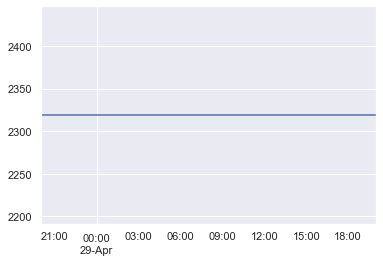

In [119]:
vol_fc = sari_mod_vol_fc.forecast(steps=24*60)
vol_fc
vol_fc.plot()

In [49]:
vol_last_5d_1min

time
2021-04-22 04:01:00    9244.0
2021-04-22 04:02:00    2860.0
2021-04-22 04:03:00    2990.0
2021-04-22 04:04:00     510.0
2021-04-22 04:05:00    1011.0
                        ...  
2021-04-28 19:56:00    6269.0
2021-04-28 19:57:00    1574.0
2021-04-28 19:58:00    2127.0
2021-04-28 19:59:00    4522.0
2021-04-28 20:00:00    2319.0
Freq: T, Name: volume, Length: 9600, dtype: float64

2021-04-28 20:01:00    2630.872724
2021-04-28 20:02:00    2582.473395
2021-04-28 20:03:00    2549.816560
2021-04-28 20:04:00    2472.193725
2021-04-28 20:05:00    2487.613057
                          ...     
2021-04-29 19:56:00    2332.136072
2021-04-29 19:57:00    2332.136072
2021-04-29 19:58:00    2332.136072
2021-04-29 19:59:00    2332.136072
2021-04-29 20:00:00    2332.136072
Freq: T, Length: 1440, dtype: float64

In [51]:
vol_cat = vol_last_5d_1min.append(vol_fc)
vol_cat

2021-04-22 04:01:00    9244.00000
2021-04-22 04:02:00    2860.00000
2021-04-22 04:03:00    2990.00000
2021-04-22 04:04:00     510.00000
2021-04-22 04:05:00    1011.00000
                          ...    
2021-04-29 19:56:00    8115.18893
2021-04-29 19:57:00    8115.18893
2021-04-29 19:58:00    8115.18893
2021-04-29 19:59:00    8115.18893
2021-04-29 20:00:00    8115.18893
Freq: T, Length: 11040, dtype: float64

In [63]:
df_last_5d_1min_close[df_last_5d_1min_close.isna()].index.size

5673

In [58]:
vol_cat[vol_cat.isna()].index.size

5673

In [69]:
df_int = df_last_5d_1min_close.interpolate()
df_int

In [78]:
vol_int = vol_last_5d_1min.interpolate()
vol_int

### Close

In [106]:
# exog cannot have NaN
# sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_last_5d_1min, order=(1,1,3)).fit()

sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_last_5d_1min.interpolate(), order=(0,0,0)).fit()
sari_mod_close_fc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  close   No. Observations:                 9600
Model:                        SARIMAX   Log Likelihood              -43193.578
Date:                Fri, 30 Apr 2021   AIC                          86391.156
Time:                        11:00:40   BIC                          86405.495
Sample:                    04-22-2021   HQIC                         86396.020
                         - 04-28-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume         0.0008      0.037      0.023      0.982      -0.071       0.073
sigma2      5.694e+08   2.24e-14   2.54e+22      0.000    5.69e+08    5.69e+08
===================================================================================
Ljung-Box (Q):                   133799.92   Jarque-Bera (JB):             29523.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+40. Standard errors may be unstable.
"""

In [101]:
sari_mod_close_fc = SARIMAX(df_int, exog=vol_int, order=(1,1,3)).fit()
# sari_mod_close_fc = SARIMAX(df_last_5d_1min_close, exog=vol_int, order=(1,1,3)).fit()

/Users/wax/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
# sari_mod_last = SARIMAX(df_last, order=(1,1,0), seasonal_order=(1,1,0,16)).fit()
# sari_mod_last = SARIMAX(df_last.dropna(), order=(1,1,0), seasonal_order=(1,1,0,16), exog=vol_last.dropna()).fit()
sari_mod_close_fc.summary()

In [107]:
close_fc = sari_mod_close_fc.forecast(steps=24*60, exog = vol_fc)

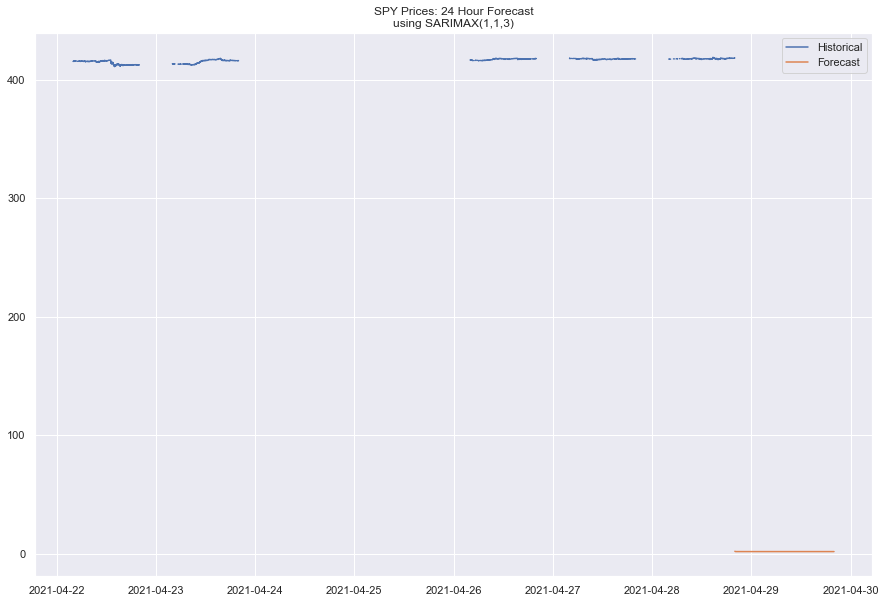

In [108]:
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(df_last_5d_1min_close, label='Historical')
ax.plot(close_fc, label='Forecast')
ax.set_title('SPY Prices: 24 Hour Forecast\nusing SARIMAX(1,1,3)')
plt.legend()

## Facebook Prophet

In [ ]:
df_pro = pd.DataFrame(df.reset_index())
df_pro.columns = ['ds','y']

In [ ]:
df_pro

In [ ]:
promod = prophet.Prophet()
promod.fit(df_pro)

In [ ]:
future = promod.make_future_dataframe(periods=16, freq=cbh)
future.tail(32)

In [ ]:
forecast = promod.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
df_pro[-16:]

In [ ]:
forecast[-32:]

In [ ]:
fig, ax = plt.subplots(figsize = (20,15))
promod.plot(forecast, ax=ax);
# start = pd.to_datetime('2021-04-23')
# end = pd.to_datetime('2021-04-26')
# ax.set_xlim(start,end)

In [ ]:
forecast.yhat.plot()

In [ ]:
fig2 = promod.plot_components(forecast)
